# Model_VGG19——test for result

In [6]:
# ================================================================
#               环境准备
# ================================================================

# 1. 安装所有系统和Python依赖
print(">>> 正在安装系统依赖库 libcairo2-dev...")
!apt-get update -qq && apt-get install -y libcairo2-dev pkg-config python3-dev > /dev/null
print(">>> 系统依赖安装完成。")

print(">>> 正在安装Python库 pycairo...")
!pip install pycairo > /dev/null
print(">>> Python库安装完成。")

# 2. 导入所有需要的库
import numpy as np
import os
from PIL import Image as PIL_Image
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import glob
import re
import chess
import chess.svg
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from keras.models import load_model

# 3. 定义所有需要的函数
def canny_edge(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(img, lower, upper)

def natural_keys(text):
    def atoi(text): return int(text) if text.isdigit() else text
    return [atoi(c) for c in re.split('(\d+)', text)]

def grab_cell_files(folder_name='./temp_cells/*'):
    img_filename_list = []
    for path_name in glob.glob(folder_name):
        img_filename_list.append(path_name)
    return img_filename_list

def classify_cells(model, img_filename_list):
    category_reference = {0: 'b', 1: 'k', 2: 'n', 3: 'p', 4: 'q', 5: 'r', 6: '1', 7: 'B', 8: 'K', 9: 'N', 10: 'P', 11: 'Q', 12: 'R'}
    pred_list = []
    for filename in img_filename_list:
        img_arr = PIL_Image.open(filename).resize((224, 224))
        if img_arr.mode != 'RGB': img_arr = img_arr.convert('RGB')
        img_data = np.array(img_arr.getdata(), np.float32).reshape(224, 224, -1)
        img_data = np.flip(img_data, axis=2); img_data[:, :, 0] -= 103.939; img_data[:, :, 1] -= 116.779; img_data[:, :, 2] -= 123.68
        img_data = np.expand_dims(img_data, axis=0)
        out = model.predict(img_data, verbose=0)
        pred_list.append(category_reference[np.argmax(out)])

    raw_fen_string = ''.join(pred_list); reversed_fen_string = raw_fen_string[::-1]
    rows_64_chars = [reversed_fen_string[i:i + 8] for i in range(0, 64, 8)]
    processed_rows = [re.sub('1+', lambda m: str(len(m.group(0))), row) for row in rows_64_chars]
    return '/'.join(processed_rows)

def fen_to_image(fen):
    try:
        board = chess.Board(fen)
        with open('current_board.svg', "w") as f: f.write(chess.svg.board(board=board))
        svg = svg2rlg('current_board.svg')
        renderPM.drawToFile(svg, 'current_board.png', fmt="PNG")
        return board
    except Exception as e:
        print(f"FEN格式错误或无法解析: {e}"); return None

def fixed_x_crop_images(img, points):
    cropped_images = []
    if len(points) < 81: return []
    for row in range(8):
        for col in range(8):
            p1_index, p3_index = row * 9 + col, (row + 1) * 9 + (col + 1)
            x_start, y_start = int(points[p1_index][0]), int(points[p1_index][1])
            x_end, y_end = int(points[p3_index][0]), int(points[p3_index][1])
            cropped = img[y_start:y_end, x_start:x_end]
            if cropped.size > 0: cropped_images.append(cropped)
    return cropped_images

def find_grid_lines_optimized(projection, min_dist=40, threshold_ratio=0.5):
    if len(projection) == 0: return []
    threshold = np.max(projection) * threshold_ratio
    peaks = np.where(projection > threshold)[0]
    if len(peaks) == 0: return []
    lines, current_line = [], [peaks[0]]
    for i in range(1, len(peaks)):
        if peaks[i] - peaks[i-1] < min_dist: current_line.append(peaks[i])
        else:
            if len(current_line) > 0: lines.append(int(np.mean(current_line)))
            current_line = [peaks[i]]
    if len(current_line) > 0: lines.append(int(np.mean(current_line)))
    return lines

print("\n>>> 环境准备完成。请立即执行第二步！")

>>> 正在安装系统依赖库 libcairo2-dev...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
>>> 系统依赖安装完成。
>>> 正在安装Python库 pycairo...
>>> Python库安装完成。

>>> 环境准备完成。请立即执行第二步！


模型 'model_VGG16.h5' 加载成功！


Saving alpha_data_image45.jpeg to alpha_data_image45 (2).jpeg
已上传文件: alpha_data_image45 (2).jpeg


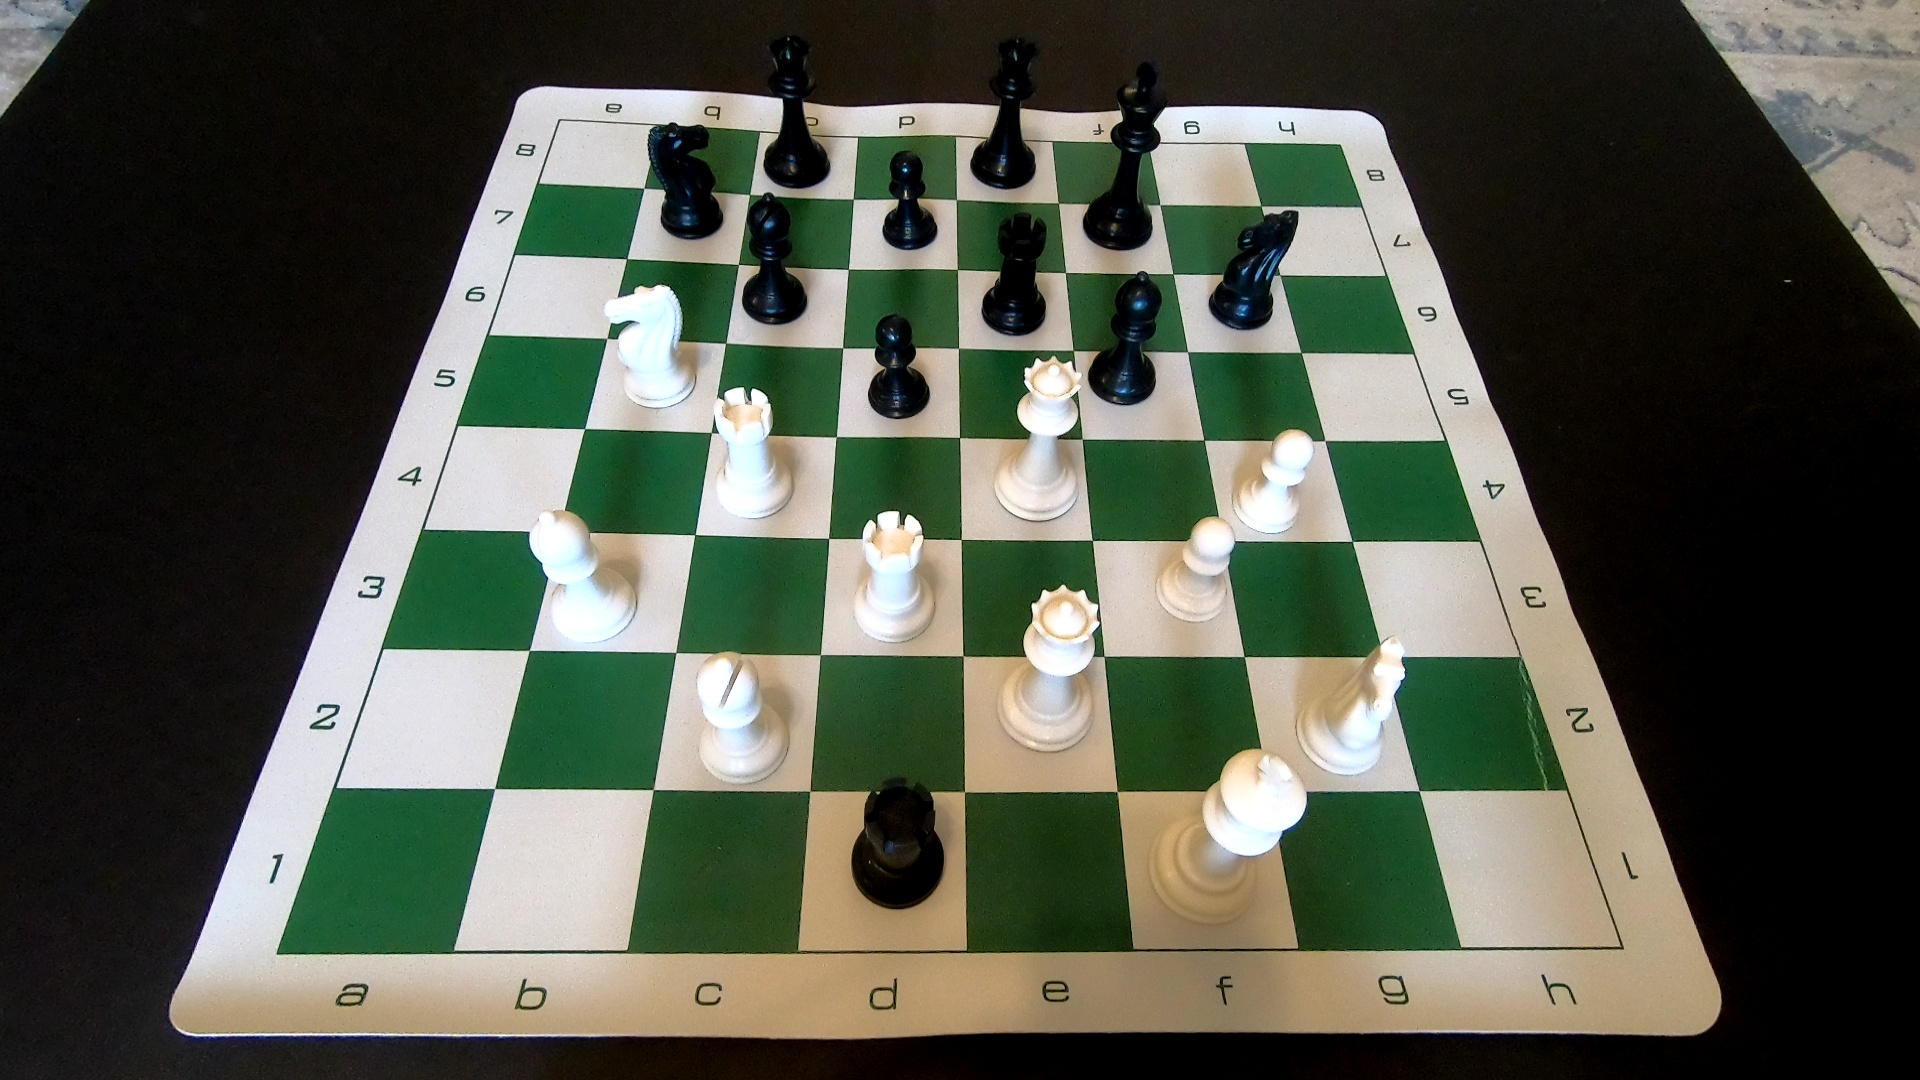

In [7]:
# 加载训练好的模型
try:
    model = load_model('model_VGG19.h5')
    print("模型 'model_VGG16.h5' 加载成功！")
except Exception as e:
    print(f"加载模型失败，请确保 'model_VGG16.h5' 文件在 '{project_path}' 目录下。错误: {e}")

# 上传棋盘图片
uploaded = files.upload()

if not uploaded:
    print("没有上传文件。")
else:
    image_path = list(uploaded.keys())[0]
    print(f"已上传文件: {image_path}")
    display(Image(image_path, width=400))

In [8]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, IntSlider
from google.colab.patches import cv2_imshow

# 确保图片路径存在
if 'image_path' in locals() and image_path:
    # --- 将所有必要的函数放在这里 ---
    def find_grid_lines_interactive(projection, min_dist, threshold_ratio):
        if len(projection) == 0: return []
        threshold = np.max(projection) * threshold_ratio
        peaks = np.where(projection > threshold)[0]
        if len(peaks) == 0: return []
        lines = []
        current_line = [peaks[0]]
        for i in range(1, len(peaks)):
            if peaks[i] - peaks[i-1] < min_dist:
                current_line.append(peaks[i])
            else:
                if len(current_line) > 0: lines.append(int(np.mean(current_line)))
                current_line = [peaks[i]]
        if len(current_line) > 0: lines.append(int(np.mean(current_line)))
        return lines

    # --- 交互式调试的主函数 ---
    def interactive_grid_finder(h_thresh, v_thresh, min_dist):
        # 1. 透视变换
        img_original = cv2.imread(image_path)
        input_pts = np.float32([[531, 17], [1371, 21], [1667, 982], [233, 979]])
        width, height = 800, 800
        output_pts = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
        M = cv2.getPerspectiveTransform(input_pts, output_pts)
        warped_img = cv2.warpPerspective(img_original, M, (width, height))

        # 2. 边缘检测
        gray = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 200)

        # 3. 投影
        vertical_projection = np.sum(edges, axis=0)
        horizontal_projection = np.sum(edges, axis=1)

        # 4. 使用滑块的值来寻找网格线
        v_lines_x = find_grid_lines_interactive(vertical_projection, min_dist, v_thresh)
        h_lines_y = find_grid_lines_interactive(horizontal_projection, min_dist, h_thresh)

        # 5. 可视化结果
        img_with_grid = warped_img.copy()
        for x in v_lines_x: cv2.line(img_with_grid, (x, 0), (x, height), (0, 0, 255), 2) # 垂直线画红色
        for y in h_lines_y: cv2.line(img_with_grid, (0, y), (width, y), (0, 255, 0), 2) # 水平线画绿色

        print(f"检测结果 -> 水平线 (H): {len(h_lines_y)}, 垂直线 (V): {len(v_lines_x)}")
        if len(h_lines_y) == 9 and len(v_lines_x) == 9:
            print("🎉 成功！已找到9x9网格。请记下这些参数值。")

        cv2_imshow(img_with_grid)

    # --- 创建交互式滑块 ---
    interactive_widget = interactive(interactive_grid_finder,
                                     h_thresh=FloatSlider(value=0.4, min=0.1, max=1.0, step=0.05, description='水平阈值 (H)'),
                                     v_thresh=FloatSlider(value=0.4, min=0.1, max=1.0, step=0.05, description='垂直阈值 (V)'),
                                     min_dist=IntSlider(value=40, min=10, max=100, step=5, description='最小间距'))

    display(interactive_widget)

else:
    print("请先上传一张图片。")

interactive(children=(FloatSlider(value=0.4, description='水平阈值 (H)', max=1.0, min=0.1, step=0.05), FloatSlider…

In [9]:
# ================================================================
#             主程序
# ================================================================

# 1. 重新挂载Drive并加载所需文件
print(">>> 正在挂载Google Drive...")
drive.mount('/content/drive')

print(">>> 正在加载模型和图片...")
try:
    # 定义文件路径
    project_path = '/content/drive/My Drive/Chess_Project/'
    model_path = os.path.join(project_path, 'model_VGG16.h5')
    # 注意：这里需要重新指定您要识别的图片路径
    image_to_process_path = os.path.join(project_path, image_path)

    # 加载模型
    model = load_model(model_path)
    print(">>> 模型加载成功。")
except Exception as e:
    print(f"加载模型或图片失败: {e}")

# 2. 运行完整的识别流程
if 'model' in locals():
    print('>>> 正在运行最终识别流程...')
    try:
        # 透视变换
        img_original = cv2.imread(image_to_process_path)
        input_pts = np.float32([[531, 17], [1371, 21], [1667, 982], [233, 979]])
        width, height = 800, 800
        output_pts = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
        M = cv2.getPerspectiveTransform(input_pts, output_pts)
        warped_img = cv2.warpPerspective(img_original, M, (width, height))

        # 网格检测
        gray = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 200)
        H_THRESHOLD, V_THRESHOLD, MIN_DIST = 0.25, 0.35, 25
        v_lines_x = find_grid_lines_optimized(np.sum(edges, axis=0), MIN_DIST, V_THRESHOLD)
        h_lines_y = find_grid_lines_optimized(np.sum(edges, axis=1), MIN_DIST, H_THRESHOLD)
        if len(v_lines_x) != 9 or len(h_lines_y) != 9:
             raise ValueError(f"投影法未能检测到9x9网格线（H:{len(h_lines_y)}, V:{len(v_lines_x)}）。")

        # 裁剪
        points = []
        for y in h_lines_y:
            for x in v_lines_x:
                points.append((x, y))
        cropped_images = fixed_x_crop_images(warped_img, points)
        if len(cropped_images) != 64: raise ValueError("裁剪失败！")

        # 分类
        temp_cell_folder = './temp_cells/'
        if not os.path.exists(temp_cell_folder): os.makedirs(temp_cell_folder)
        for f in os.listdir(temp_cell_folder): os.remove(os.path.join(temp_cell_folder, f))
        for i, crop_img in enumerate(cropped_images):
            cv2.imwrite(os.path.join(temp_cell_folder, f'cell_{i}.jpeg'), crop_img)
        img_filename_list = sorted(glob.glob(os.path.join(temp_cell_folder, '*')), key=os.path.getmtime)
        os.chdir(project_path) # 切换工作目录以加载模型
        fen = classify_cells(model, img_filename_list)

        # 显示结果
        print("\n识别完成！")
        print("="*30)
        print(f"检测到的FEN字符串: {fen}")
        board = fen_to_image(fen)
        if board:
            print("\n识别出的棋盘布局:")
            print(board)
            print("\n生成的棋盘图像 'current_board.png':")
            display(PIL_Image.open('current_board.png'))

    except Exception as e:
        print(f"\n处理时发生错误: {e}")

>>> 正在挂载Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> 正在加载模型和图片...


>>> 模型加载成功。
>>> 正在运行最终识别流程...

识别完成！
检测到的FEN字符串: NKrkr1Nr/NrKrK1rr/rrrKrrKr/QrK1Nr2/r1QkrbQr/rkkprrKK/rkrbr2r/rrkkr2r
FEN格式错误或无法解析: cannot import desired renderPM backend rlPyCairo
Seek advice at the users list see
https://pairlist2.pair.net/mailman/listinfo/reportlab-users
